# Projet MML Donnée de Valeur Foncière:

Objectifs:
- Prédire une valeur de vente à partir de features d'un bien immobilier.
- Prédire l'évolution de la valeur du bien dans le temps.

# Imports

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Chargement des données

In [2]:
def load_dataset(up_to= None):
    '''
    Charge les fichiers DVF jusqu'à une année donnée (incluse).

    Paramètres:
        up_to (str): Année maximale à charger, ex: "2020", "2023".

    Return:
        DataFrame Pandas combiné sans doublons.
    '''

    data_files = {
        "2019": "data/ValeursFoncieres-2019-S2.txt",
        "2020": "data/ValeursFoncieres-2020.txt",
        "2021": "data/ValeursFoncieres-2021.txt",
        "2022": "data/ValeursFoncieres-2022.txt",
        "2023": "data/ValeursFoncieres-2023.txt",
        "2024": "data/ValeursFoncieres-2024-S1.txt",
    }

    valid_years = list(data_files.keys())
    if (up_to is not None) and (up_to not in valid_years):
        print("Erreur: \"up_to\" doit être une année entre \"2019\" et \"2024\".")
        return -1

    data_list = []
    for year, path in data_files.items():
        print(f"Chargement {year}...")
        df = pd.read_csv(path, delimiter='|', dtype= str)
        data_list.append(df)
        if (up_to is not None) and (year == up_to):
            break

    data = pd.concat(data_list, ignore_index= True)
    # data.drop_duplicates(inplace=True) #? Fait crash le kernel, désactivé pour le moment
    print(f"\n{len(data):,} lignes chargées au total.")

    return data

In [3]:
data = load_dataset(up_to= "2021") #TODO crash toujour lorsque load au dessus de 2021

Chargement 2019...
Chargement 2020...
Chargement 2021...

10,162,527 lignes chargées au total.


# Parsing et visualisation des données

## Fonctions

### 1. Parsing

In [ ]:
def parse_dataset(data, min_price= None, max_price= None, all_local_type= False):
    '''
    Parsing des données, on ne garde que les lignes des ventes et de certains types de local.
    Seule les colonnes suivantes sont gardées : "Valeur fonciere", "Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales".
    Les lignes comportant des NaN sont supprimées.
    Ajout de colonnes pour "Année", "Mois", "Jour".
    Valeurs de target plafonnée.

    Paramètres:
        data (DataFrame): strucutre d'un fichier DVF.
        max_price (float): valeur maximum de target.
        all_local_type (bool): définit si l'on exclu certains types de local ou non.

    Retour:
        DataFrames Pandas, X contenant les features et y contenant la target.
    '''

    if (max_price) and (max_price <= 0):
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if (min_price) and (min_price <= 0):
        print("Erreur: \"max_price\" doit être > 0.")
        return -1
    if (max_price) and (min_price) and (min_price >= max_price):
        print("Erreur: \"min_price\" doit être < à \"max_price\"")
        return -1
    if (all_local_type is not False) and (all_local_type is not True):
        print("Erreur: \"all_local_type\" doit être un booleen.")
        return -1

    data = data[(data["Nature mutation"] == "Vente")]

    if all_local_type == False:
        data = data[(data["Type local"] == "Maison") | (data["Type local"] == "Appartement")]

    data = data.dropna(subset= ["Date mutation", "Valeur fonciere", "Code departement", "Type local", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"])
    data["Valeur fonciere"] = data["Valeur fonciere"].str.replace(",", ".", regex= False).astype(float)

    if max_price:
        data = data[(data["Valeur fonciere"] < max_price)]
    if min_price:
        data = data[(data["Valeur fonciere"] >= min_price)]

    data["Date mutation"] = pd.to_datetime(data["Date mutation"], format="%d/%m/%Y", errors="coerce")
    data["Année"] = data["Date mutation"].dt.year
    data["Mois"] = data["Date mutation"].dt.month
    data["Jour"] = data["Date mutation"].dt.day
    data["Surface reelle bati"] = data["Surface reelle bati"].str.replace(",", ".", regex= False).astype(float)
    data["Nombre pieces principales"] = data["Nombre pieces principales"].astype(int)
    data["Surface terrain"] = data["Surface terrain"].str.replace(",", ".", regex= False).astype(float)

    features = ["Date mutation", "Code departement", "Type local", "Surface terrain", "Surface reelle bati", "Nombre pieces principales", "Année", "Mois", "Jour"]
    target = "Valeur fonciere"
    X = data[features]
    y = data[target]

    return X, y

### 2. Visualisation des données

In [5]:
def print_stats(X):
    ''''''

    print("Shape des features:", X.shape)
    print("Colonnes:", X.columns.tolist())
    print("\nAperçu des données:")
    display(X.head())
    print("\nRésumé statistique des variables numériques:")
    display(X.describe())
    print("\nRépartition des types de biens:")
    print(X["Type local"].value_counts())

    return

def plot_correlation_matrix(X):
    ''''''

    X_copy = X.copy()
    numerical_features = ["Date mutation", "Surface terrain", "Surface reelle bati", "Nombre pieces principales"]
    corr_matrix = X_copy[numerical_features].corr()

    plt.figure(figsize= (10, 6))
    plt.imshow(corr_matrix, cmap= "Reds")
    plt.xticks(ticks= np.arange(len(numerical_features)), labels=numerical_features, rotation= 45)
    plt.yticks(ticks= np.arange(len(numerical_features)), labels=numerical_features)
    plt.title("Matrice de corrélation")
    for i in range(len(numerical_features)):
        for j in range(len(numerical_features)):
            value = corr_matrix.iloc[i, j]
            plt.text(j, i, f"{value:.2f}", ha= "center", va= "center", color= "black")
    plt.tight_layout()
    plt.show()

    return

def hist_valeur_fonciere(y):
    ''''''

    plt.figure(figsize= (20, 3))
    plt.hist(y, bins= 100, color= "r", edgecolor='black')
    plt.title("Distribution de la valeur foncière")
    plt.xlabel("Valeur foncière (€)")
    plt.ylabel("Nombre de ventes")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

def hist_type_departement(X, y):
    ''''''

    X_copy = X.copy()
    X_copy["Valeur fonciere"] = y
    mean_values_property_type = X_copy.groupby("Type local")["Valeur fonciere"].mean().sort_values()
    mean_values_departement = X_copy.groupby("Code departement")["Valeur fonciere"].mean().sort_values()
    pivot = X_copy.pivot_table(
        values="Valeur fonciere",
        index="Code departement",
        columns="Type local",
        aggfunc="mean"
    )

    plt.figure(figsize= (20, 8))

    plt.subplot(311)
    plt.bar(mean_values_property_type.index, mean_values_property_type.values, edgecolor= "black", color= "r", width= .1)
    plt.ylabel("Valeur foncière moyenne (€)")
    plt.title("Valeur foncière moyenne par type de bien")

    plt.subplot(312)
    plt.bar(mean_values_departement.index, mean_values_departement.values, edgecolor= "black", color= "r", width= .5)
    plt.xticks(rotation=45)
    plt.ylabel("Valeur foncière moyenne (€)")
    plt.title("Valeur foncière moyenne par département")
    plt.xlim(-1, 97)

    plt.subplot(313)
    plt.imshow(pivot.T, cmap='Reds', aspect= "auto")
    plt.colorbar(label="Valeur foncière moyenne (€)")
    plt.xticks(ticks= range(len(pivot.index)), labels= pivot.index, rotation= 45)
    plt.yticks(ticks= range(len(pivot.columns)), labels= pivot.columns)
    plt.title("Prix moyen par type de bien et département")
    plt.xlabel("Département")

    plt.tight_layout()
    plt.show()

    return

def hist_divers(X, y, scale= None):
    ''''''

    X_copy = X.copy()
    X_copy["Valeur fonciere"] = y
    grouped = X_copy.groupby(["Année", "Mois"])["Valeur fonciere"]
    means = grouped.agg(['mean', 'std']).reset_index()
    means["Date"] = pd.to_datetime(means["Année"].astype(str) + "-" + means["Mois"].astype(str) + "-01")
    lower_err = np.minimum(means["mean"], means["std"])
    upper_err = means["std"]
    yerr = [lower_err, upper_err]

    plt.figure(figsize= (20, 8))

    plt.subplot(311)
    plt.plot(means["Date"], means["mean"], color= "r", label= "Moyenne")
    if (scale == "log"):
        plt.yscale("log")
        plt.title("Évolution du prix moyen des ventes dans le temps (echelle log)")
    else:
        plt.errorbar(means["Date"], means["mean"], yerr, ls= "", marker= ".", capsize= 2, color= "black", label= "Ecart-type")
        plt.legend()
        plt.title("Évolution du prix moyen des ventes dans le temps")
    plt.ylabel("Prix moyen (€)")
    plt.grid(True, alpha= .4)

    plt.subplot(312)
    plt.scatter(X_copy["Date mutation"], X_copy["Valeur fonciere"], s= 1, alpha= .1, color= 'r')
    if (scale == "log"):
        plt.yscale("log")
        plt.title("Valeur Foncière à différentes dates (echelle log)")
    else:
        plt.title("Valeur Foncière à différentes dates")
    plt.ylabel("Valeur Foncière (€)")
    plt.grid(True, alpha= .4)

    plt.subplot(313)
    plt.scatter(X_copy["Date mutation"], X_copy["Valeur fonciere"], s= 1, alpha= .2, marker= ".", color= "r")
    plt.ylabel("Valeur foncière (€)")
    if (scale == "log"):
        plt.yscale("log")
        plt.title("Valeurs foncière sur 10 jours (echelle log)")
    else:
        plt.title("Valeurs foncière sur 10 jours")
    plt.xlim(pd.Timestamp("2019-07-07"), pd.Timestamp("2019-07-20"))

    plt.tight_layout()
    plt.show()

    return

def visualize_dataset(X, y):
    '''
    Affiche differents informations sur le dataset.
    
    Paramètres:
        X (DataFrame): DataFrame contenant les features.
        y (Series): Serie contenant la target.

    Retour:
        None
    '''

    print_stats(X)
    plot_correlation_matrix(X)
    hist_valeur_fonciere(y)
    hist_type_departement(X, y)
    hist_divers(X, y)
    hist_divers(X, y, "log")

    return

## Dataset complet :

Shape des features: (3052179, 9)
Colonnes: ['Date mutation', 'Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Année', 'Mois', 'Jour']

Aperçu des données:


,Date mutation,Code departement,Type local,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
0,2019-07-01,01,Maison,695.0,150.0,5,2019,7,1
1,2019-07-04,01,Maison,888.0,94.0,4,2019,7,4
2,2019-07-04,01,Maison,500.0,94.0,4,2019,7,4
3,2019-07-04,01,Maison,522.0,90.0,3,2019,7,4
5,2019-07-03,01,Maison,2483.0,110.0,5,2019,7,3



Résumé statistique des variables numériques:


,Date mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
count,3052179,3.052179e+06,3.052179e+06,3.052179e+06,3.052179e+06,3.052179e+06,3.052179e+06
mean,2020-11-25 15:58:33.406914816,1.356999e+03,1.101635e+02,2.853575e+00,2.020310e+03,7.595469e+00,1.709966e+01
min,2019-07-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00
25%,2020-04-15 00:00:00,2.700000e+02,2.500000e+01,0.000000e+00,2.020000e+03,5.000000e+00,9.000000e+00
50%,2020-12-23 00:00:00,5.230000e+02,7.800000e+01,3.000000e+00,2.020000e+03,8.000000e+00,1.700000e+01
75%,2021-07-20 00:00:00,1.000000e+03,1.100000e+02,4.000000e+00,2.021000e+03,1.000000e+01,2.500000e+01
max,2021-12-31 00:00:00,2.960000e+06,3.129620e+05,1.090000e+02,2.021000e+03,1.200000e+01,3.100000e+01
std,NaN,7.864556e+03,8.284836e+02,2.265820e+00,7.594802e-01,3.269206e+00,9.008043e+00



Répartition des types de biens:
Type local
Maison                                      1830222
Dépendance                                   672782
Appartement                                  364706
Local industriel. commercial ou assimilé     184469
Name: count, dtype: int64


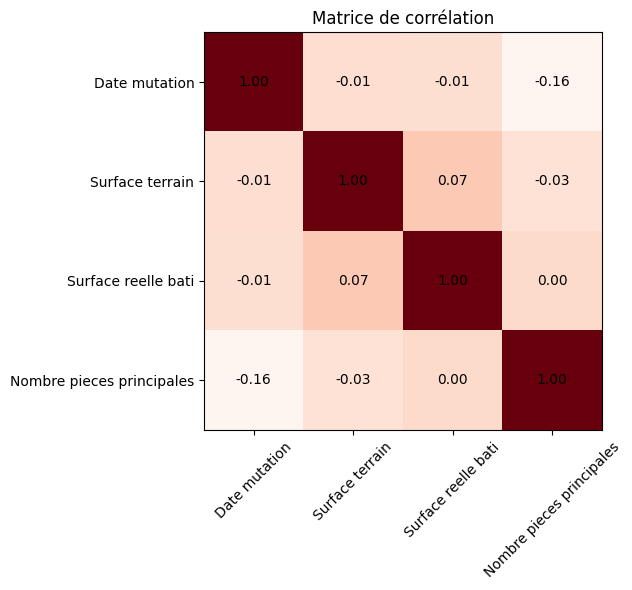

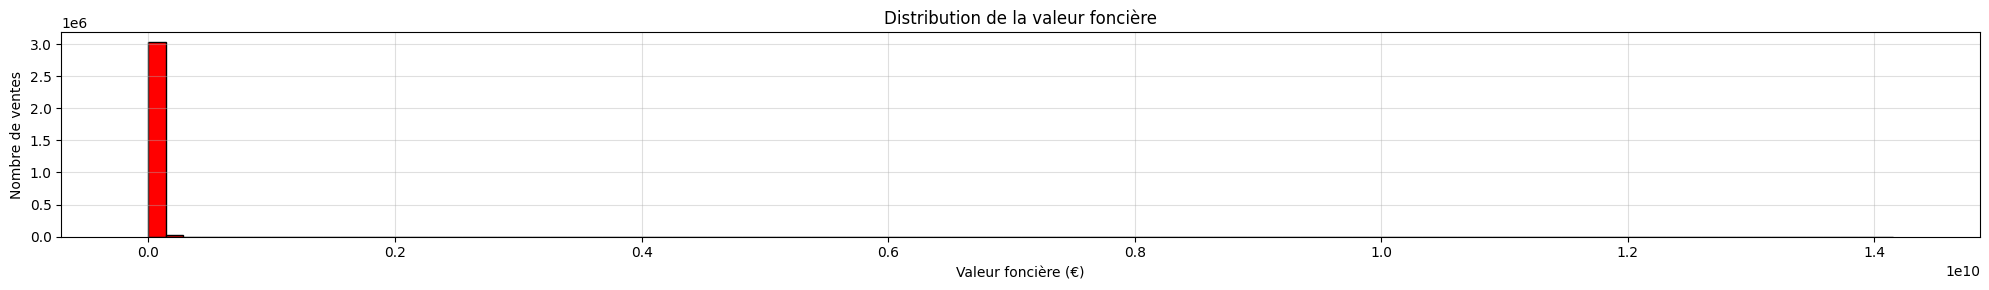

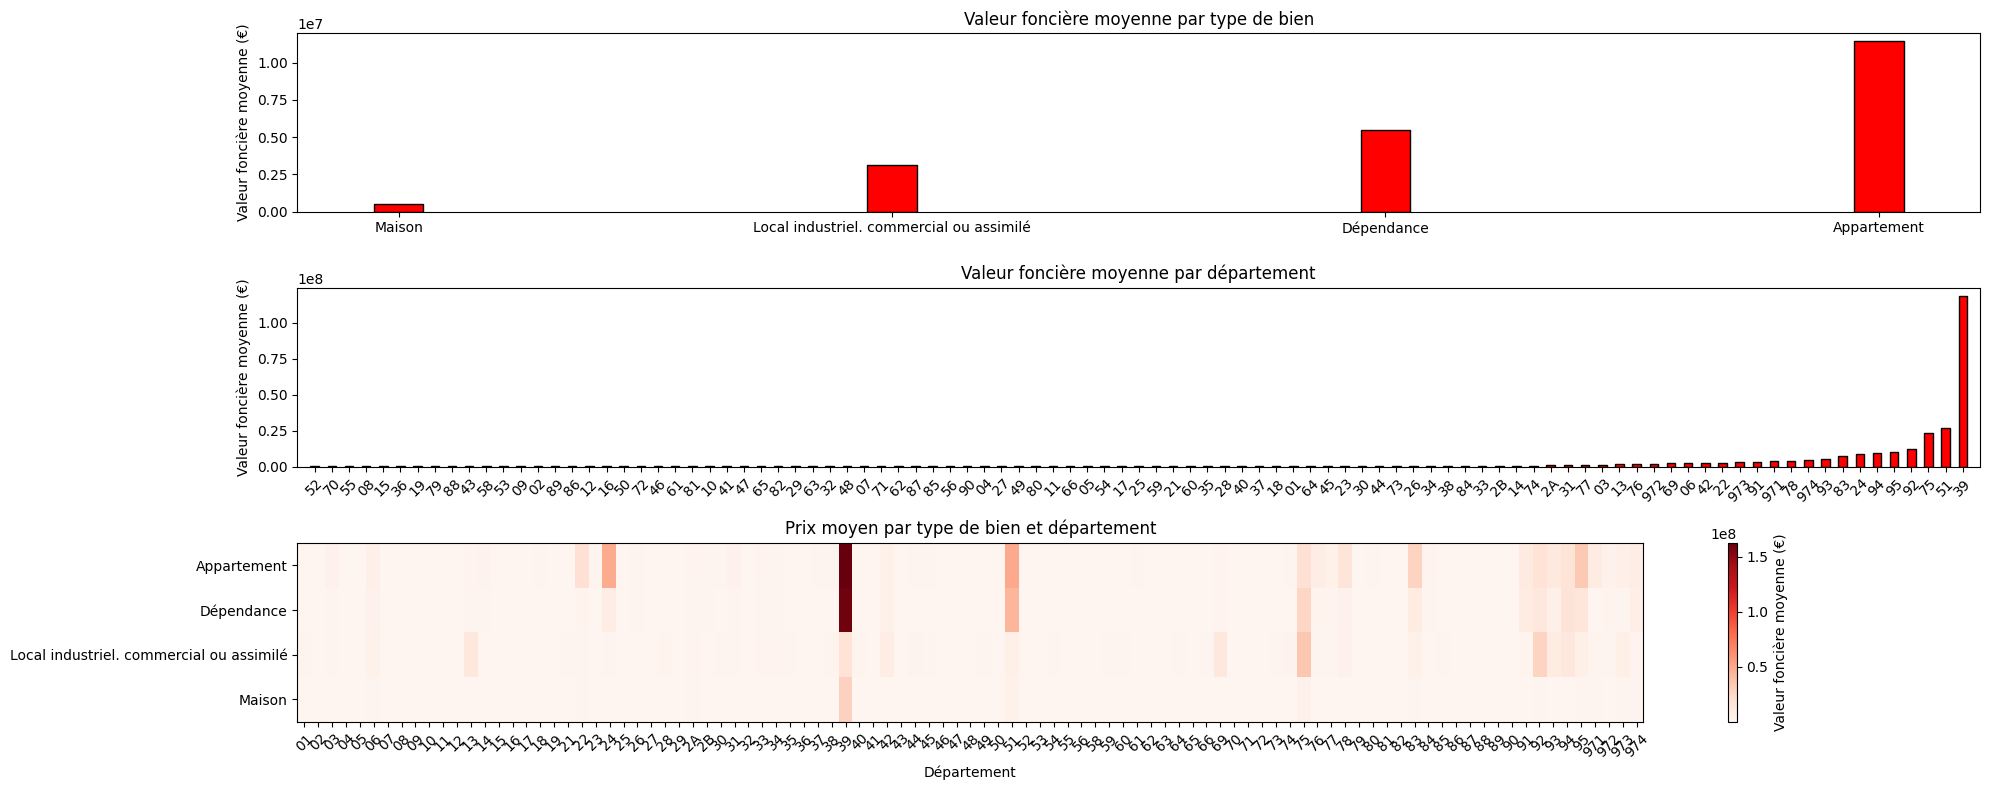

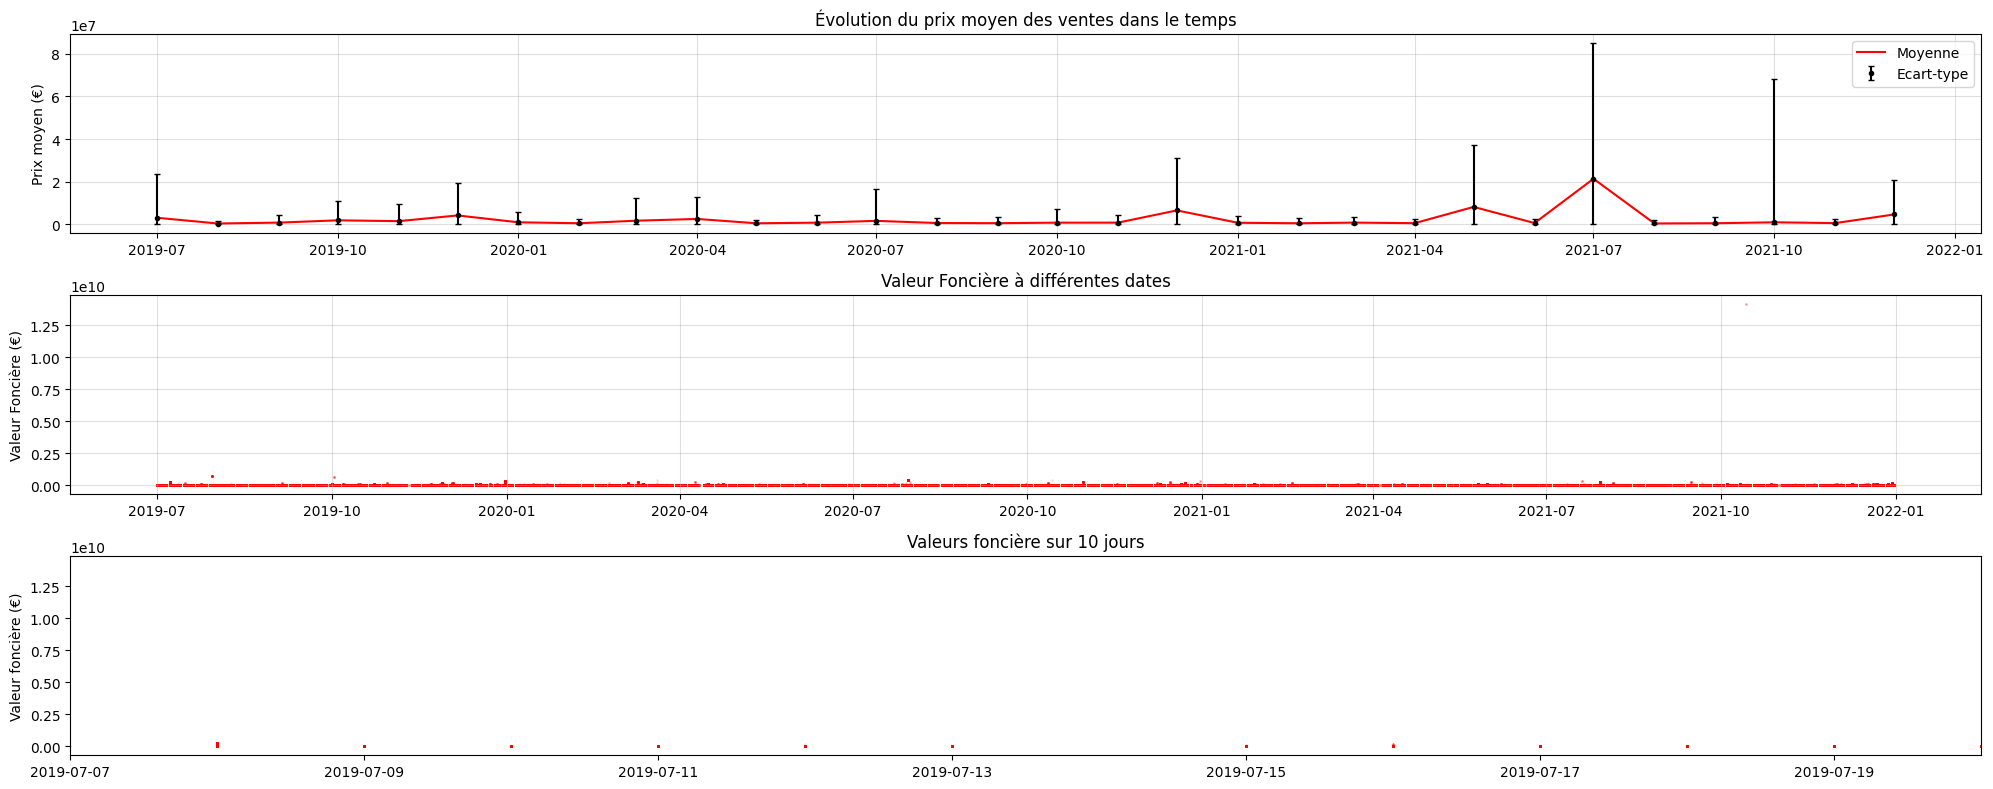

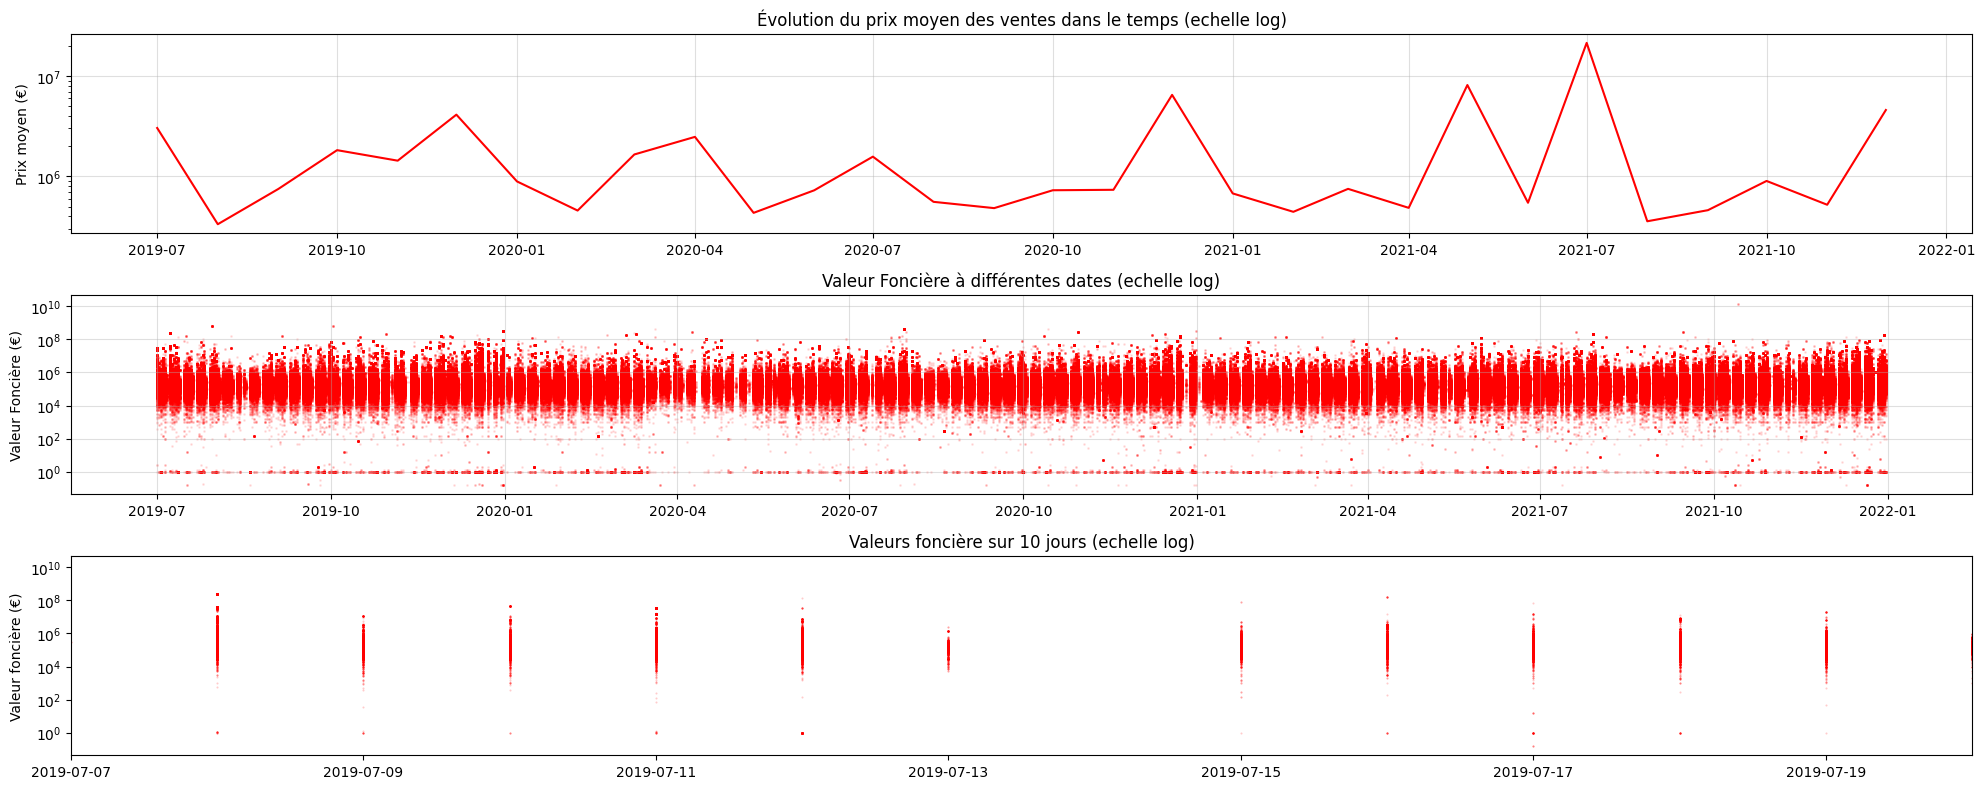

In [6]:
X, y = parse_dataset(data, all_local_type= True)
visualize_dataset(X, y)

On voit qu'il n'y a aucune correlation lorsque l'on prends la totalité des données, les locaux industriels biaisent les relations entre nombre de pièces et surface ainsi que surface et prix.

Présences de valeurs absurdes (réeles cependant), lorsque l'on tronque les valeurs pour ne garder que les ventes en dessous de 1.5 Millions d'euros on voit des tendances et des saisonnalité apparaître.

## Dataset tronqué (en valeur foncière et en type de bien) :

Shape des features: (2121866, 9)
Colonnes: ['Date mutation', 'Code departement', 'Type local', 'Surface terrain', 'Surface reelle bati', 'Nombre pieces principales', 'Année', 'Mois', 'Jour']

Aperçu des données:


,Date mutation,Code departement,Type local,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
0,2019-07-01,01,Maison,695.0,150.0,5,2019,7,1
1,2019-07-04,01,Maison,888.0,94.0,4,2019,7,4
2,2019-07-04,01,Maison,500.0,94.0,4,2019,7,4
3,2019-07-04,01,Maison,522.0,90.0,3,2019,7,4
5,2019-07-03,01,Maison,2483.0,110.0,5,2019,7,3



Résumé statistique des variables numériques:


,Date mutation,Surface terrain,Surface reelle bati,Nombre pieces principales,Année,Mois,Jour
count,2121866,2.121866e+06,2.121866e+06,2.121866e+06,2.121866e+06,2.121866e+06,2.121866e+06
mean,2020-10-20 12:57:31.046956032,9.941727e+02,9.810929e+01,4.002983e+00,2.020221e+03,7.475681e+00,1.691177e+01
min,2019-07-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,2.019000e+03,1.000000e+00,1.000000e+00
25%,2020-02-18 00:00:00,2.630000e+02,6.800000e+01,3.000000e+00,2.020000e+03,5.000000e+00,9.000000e+00
50%,2020-11-06 00:00:00,5.000000e+02,9.000000e+01,4.000000e+00,2.020000e+03,8.000000e+00,1.700000e+01
75%,2021-06-19 00:00:00,8.940000e+02,1.200000e+02,5.000000e+00,2.021000e+03,1.000000e+01,2.500000e+01
max,2021-12-31 00:00:00,2.448310e+06,1.640000e+03,1.090000e+02,2.021000e+03,1.200000e+01,3.100000e+01
std,NaN,5.286516e+03,4.971822e+01,1.645394e+00,7.663304e-01,3.305175e+00,8.968217e+00



Répartition des types de biens:
Type local
Maison         1814777
Appartement     307089
Name: count, dtype: int64


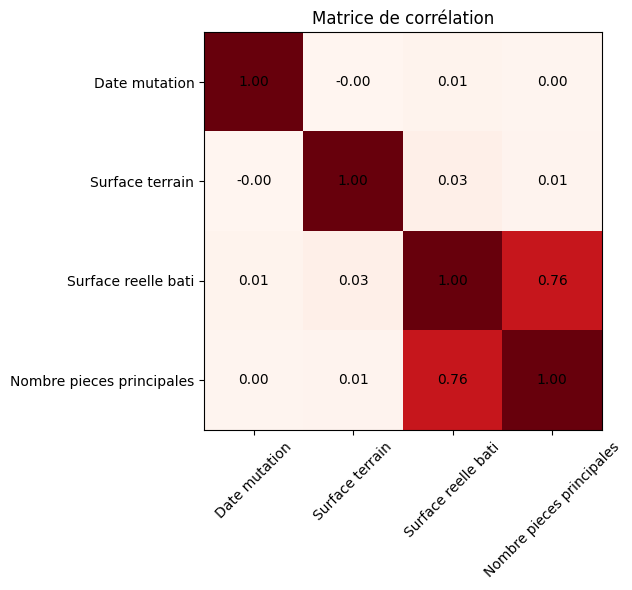

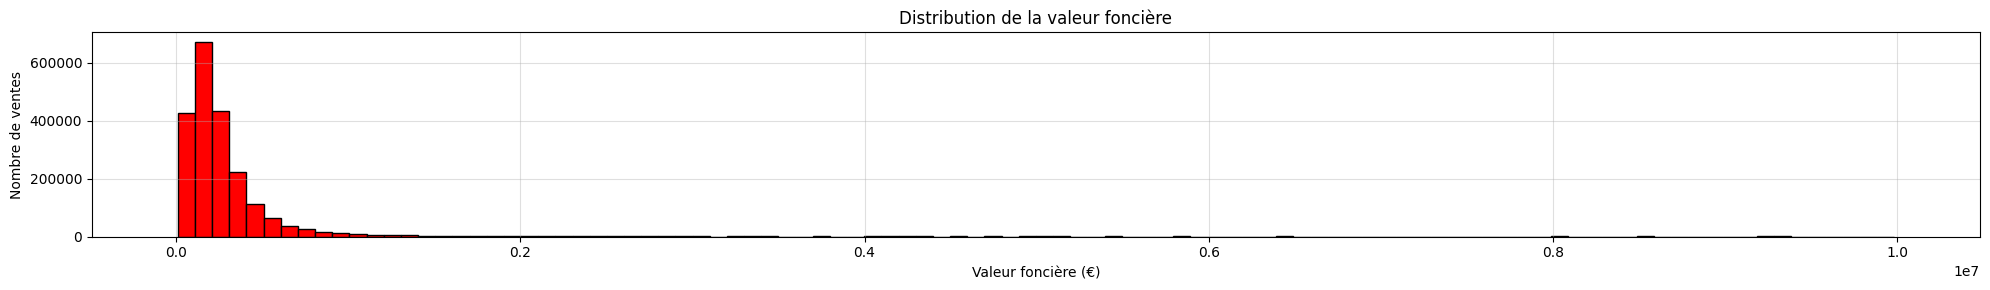

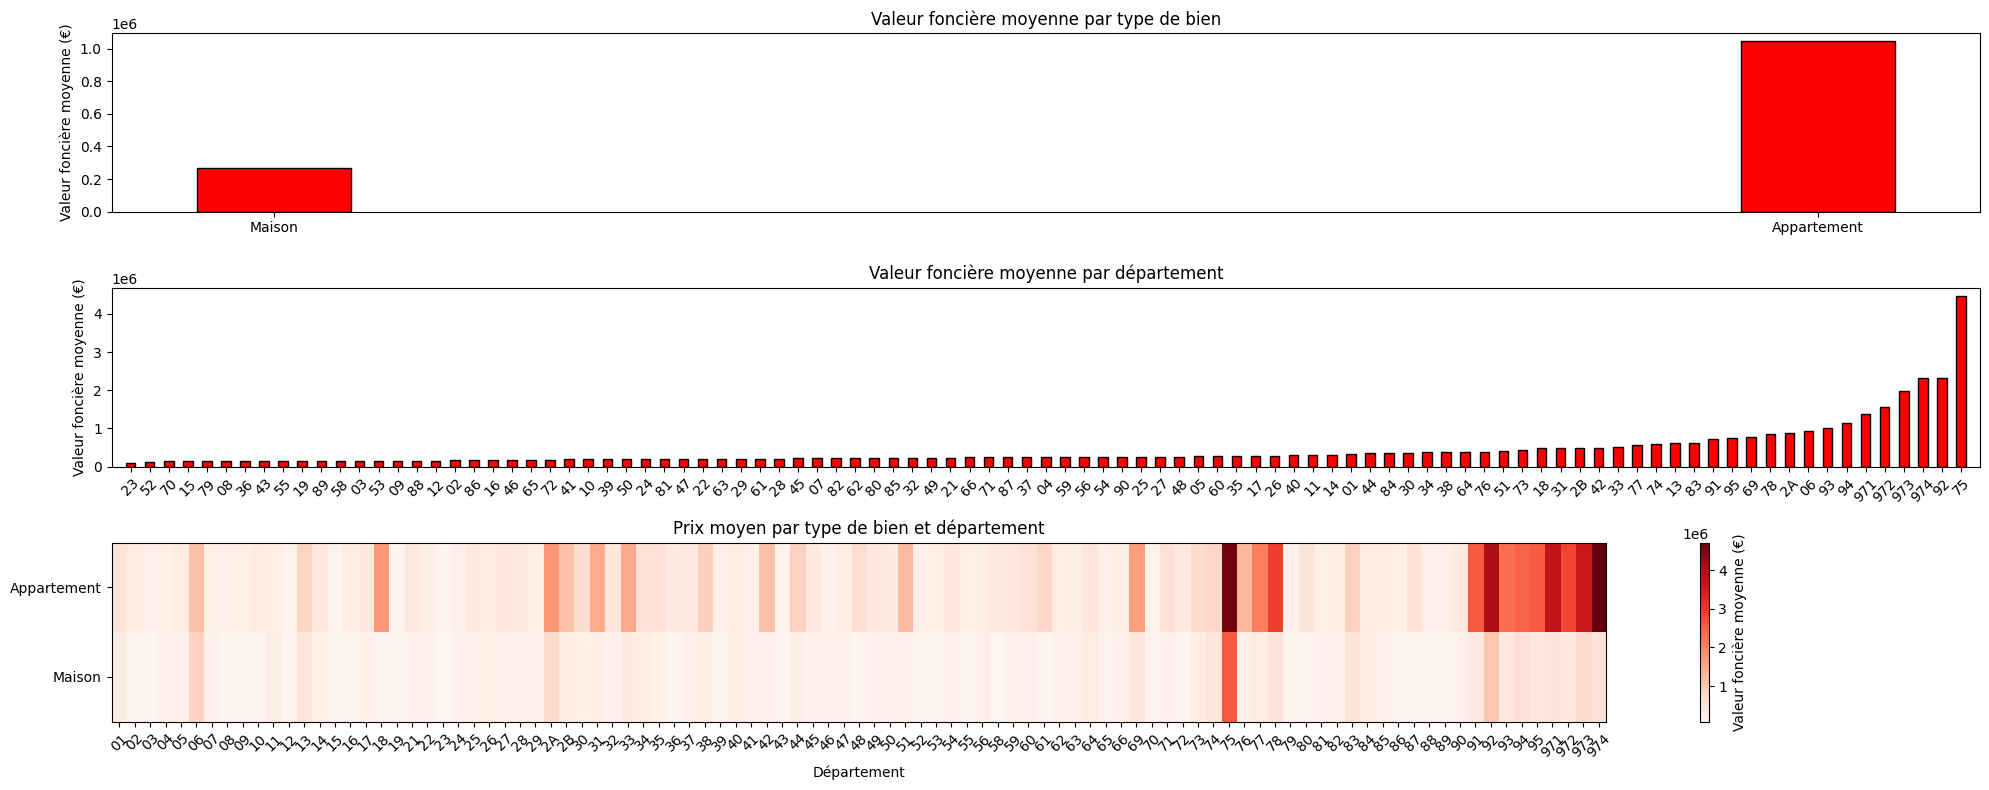

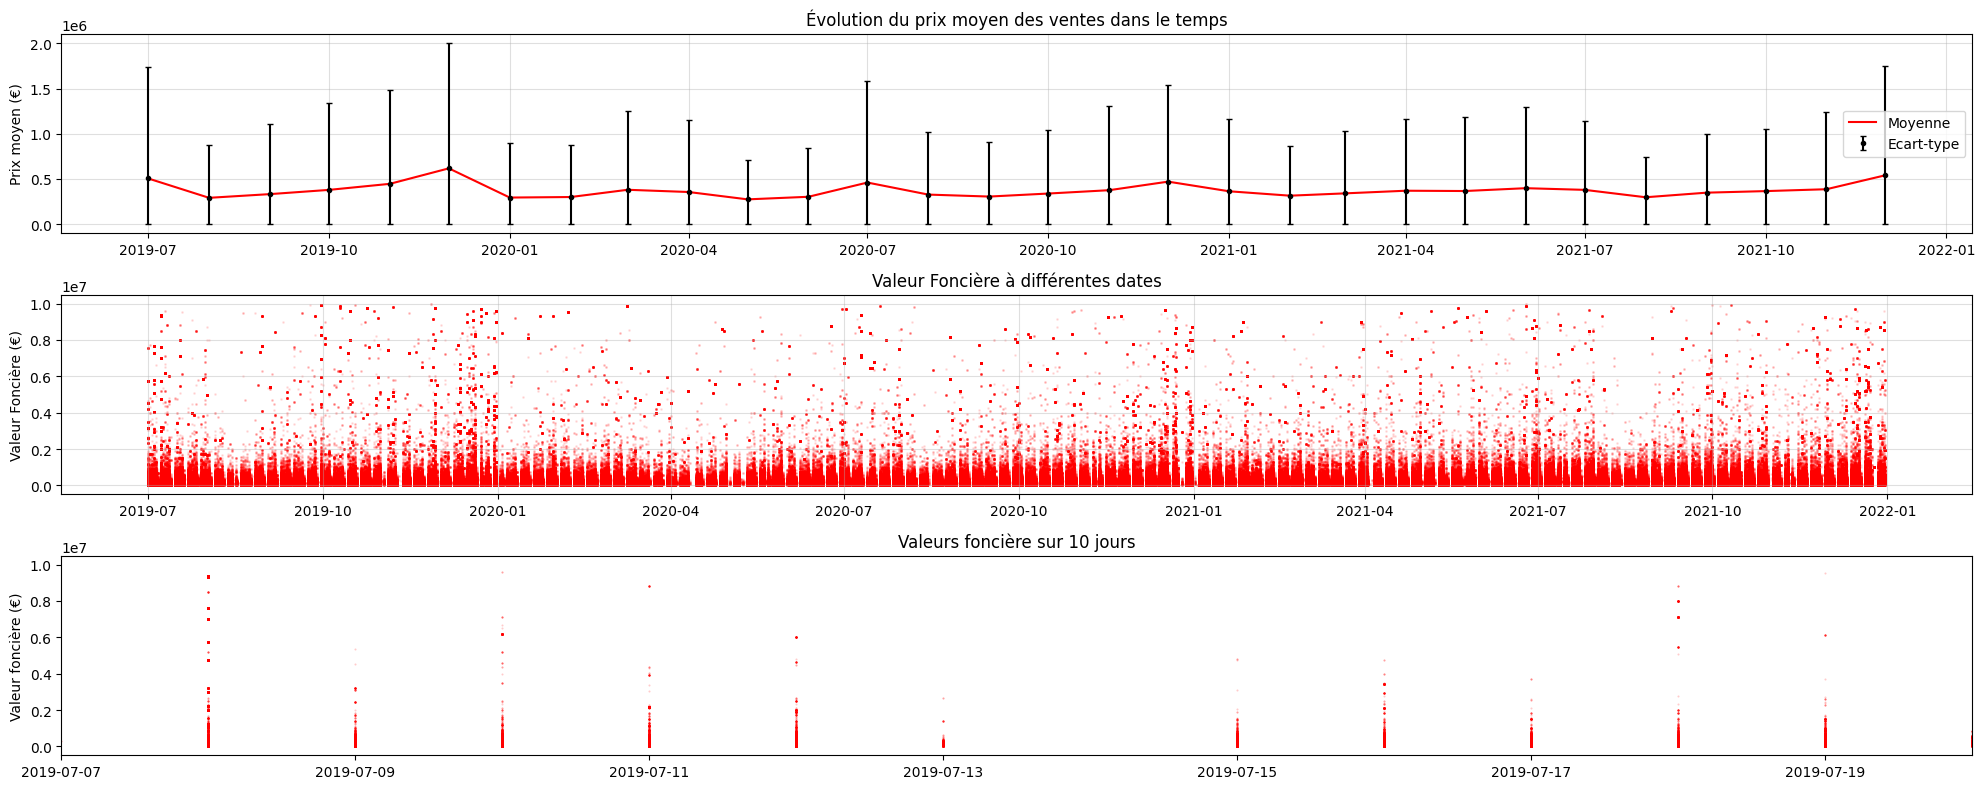

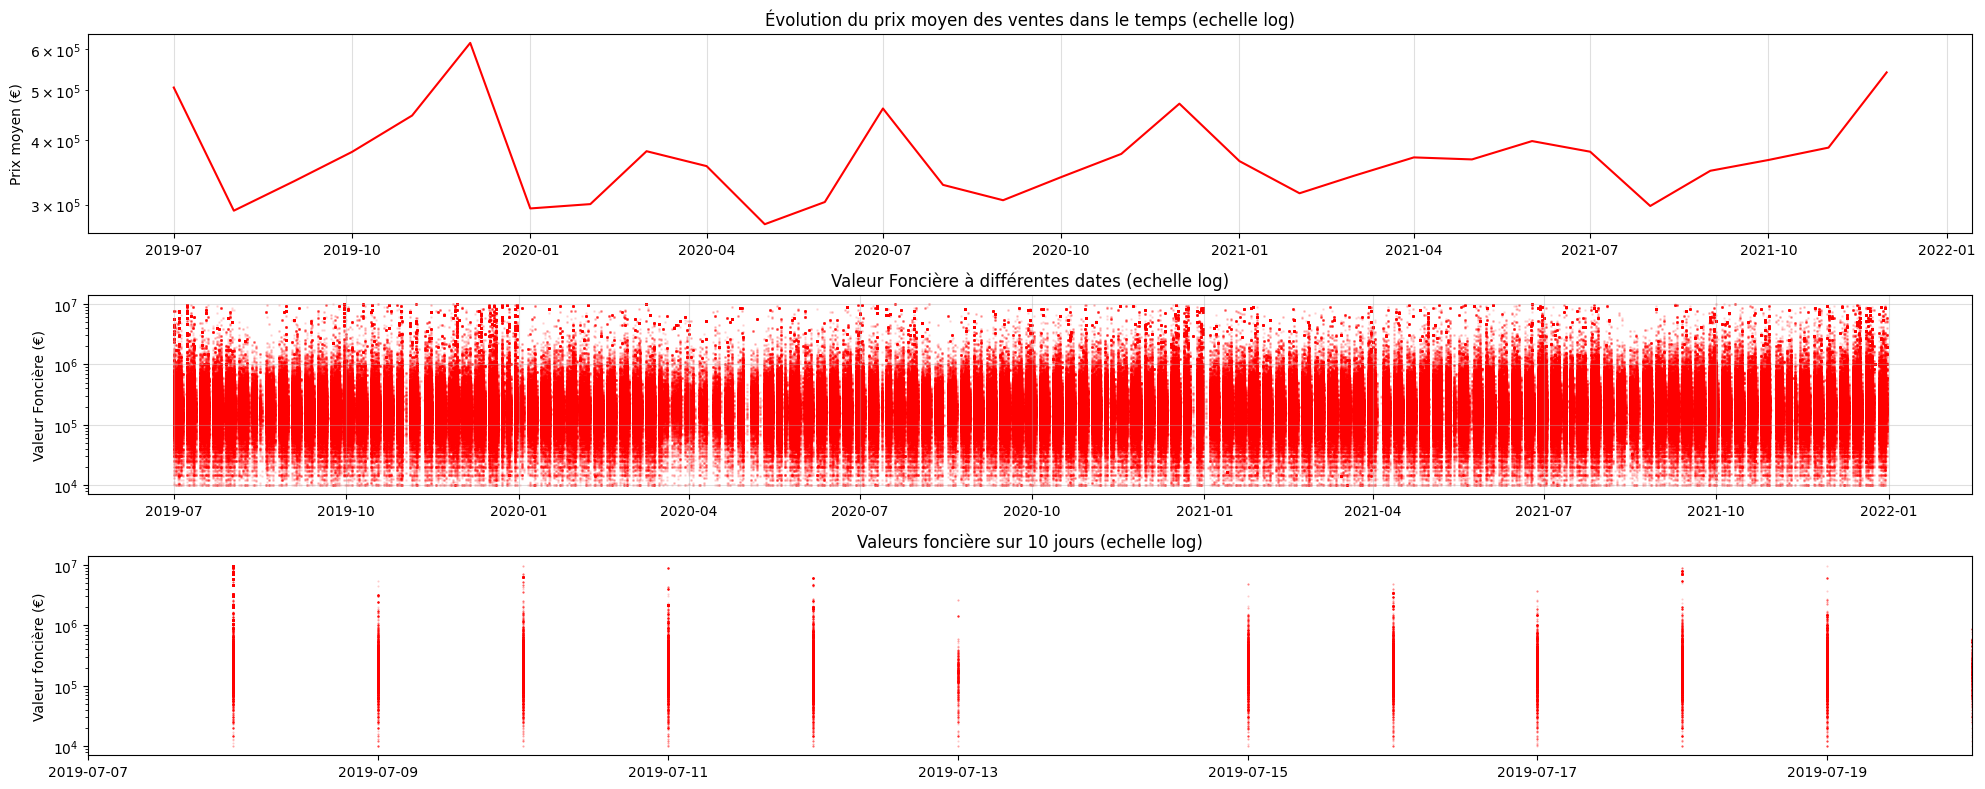

In [38]:
X_trunc, y_trunc = parse_dataset(data, min_price= 10**4, max_price= 10**7) #? max_price= 10^7 ?
visualize_dataset(X_trunc, y_trunc)

# PCA et Visualisation

On a entre 104 et 106 features apres processing des données, on regarde si une diminution de dimention par PCA est utile.

## Fonctions

In [8]:
def encode_dataset(X):
    '''
    Normalise et classifie X.

    Paramètres:
        X (Dataframe): DataFrame contenant les features.

    Retour:
        La DataFrame d'entrée avec ses valeurs processées.
    '''

    categorical_features = ["Code departement", "Type local"]
    numeric_features = [ "Année", "Mois", "Jour", "Surface reelle bati", "Nombre pieces principales", "Surface terrain"]
    preprocessor = ColumnTransformer(transformers= [('num', StandardScaler(), numeric_features),('cat', OneHotEncoder(handle_unknown= 'ignore'), categorical_features)])
    X_processed = preprocessor.fit_transform(X)

    return X_processed

def do_pca(X, n_components= 10):
    '''
    Reduction dimensionnelle par PCA de l'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        Données transformées.
    '''

    X_encoded = encode_dataset(X)
    pca = PCA(n_components= n_components)
    X_pca = pca.fit_transform(X_encoded)

    return X_pca

def plot_explained_variance(X, n_components= 10):
    '''
    Affiche la variance expliquée cumulée pour une PCA de n_components sur les données d'entrée.

    Paramètres:
        X (DataFrame): données d'entrée.
        n_components (int): nombre de composantes principales à conserver.

    Retour:
        None
    '''

    X_encoded = encode_dataset(X)
    pca = PCA(n_components= n_components)
    pca.fit(X_encoded)
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    n = np.arange(1, len(cumulative_variance) + 1)

    plt.figure(figsize= (10, 4))
    plt.plot(n, cumulative_variance, marker= "o", color= "r", ls= "--")
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Variance expliquée cumulée")
    plt.title("Variance expliquée cumulée par PCA")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

## Affichage

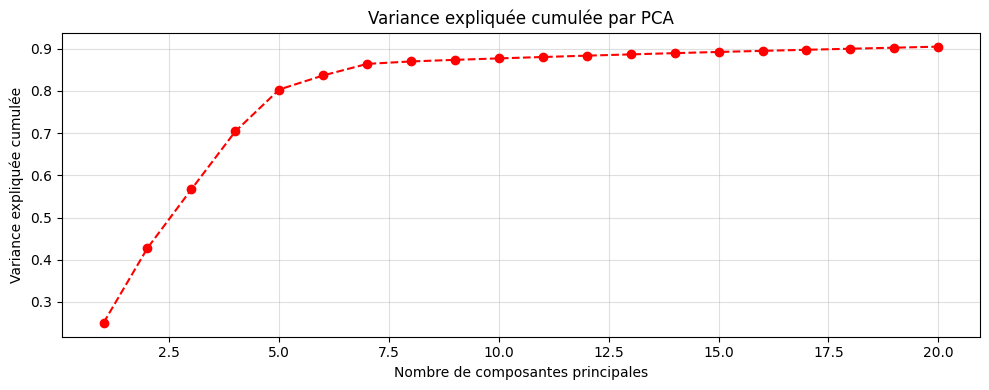

In [9]:
plot_explained_variance(X_trunc, 20)

## PCA

On voit que une PCA à 10 composantes cumule plus de 80% de la variance expliquée.

In [10]:
X_pca = do_pca(X_trunc)
print("Shape des features après PCA:", X_pca.shape)

Shape des features après PCA: (2121866, 10)


# Clustering

Existe t-il des sous-groupes bien séparés ? -> Clustering pour verifier.

Exemple de sous groupes potentiels :
- Appartement urbain compact.
- Bien haut de gamme avec grand terrain en zone rurale.
- etc...

In [39]:
#* split des sets pour fine tune les hyperparametres du clustering
X_train, X_test, y_train, y_test = train_test_split(X_trunc, y_trunc, test_size= .01, shuffle= True) #* moins de 10k points
print(X_test.shape)

(21219, 9)


## Fonctions

In [12]:
def plot_elbow_method(X, k_max= 10, n_components= 10):
    '''
    Affiche le diagramme du coude (inertie en fonction du nombre de clusters k).
    
    Paramètres:
        X (DataFrame): données brutes.
        k_max (int): nombre maximum de clusters testés.
        n_components (int): nombre de composantes à utiliser pour clustering.

    Retour:
        None
    '''

    X_pca = do_pca(X, n_components)
    inertias = []
    ks = np.arange(2, k_max + 1)

    for k in ks:
        kmeans = KMeans(n_clusters= k, n_init= "auto", random_state= 42)
        kmeans.fit(X_pca)
        inertias.append(kmeans.inertia_)

    plt.figure(figsize= (10, 4))
    plt.plot(ks, inertias, marker= "o", ls= "--", color= "r")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertie intra-cluster")
    plt.title("Elbow methode pour choisir K")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

def plot_silhouette_scores(X, k_max= 10, n_components= 10):
    '''
    Affiche le score de silhouette en fonction du nombre de clusters k.

    Paramètres:
        X (DataFrame): données brutes.
        k_max (int): nombre max de clusters testés.
        n_components (int): nombre de composantes PCA utilisées.

    Retour:
        None
    '''

    X_pca = do_pca(X, n_components)
    silhouette_scores = []
    ks = np.arange(2, k_max + 1)

    for k in ks:
        kmeans = KMeans(n_clusters= k, n_init= "auto", random_state= 42)
        labels = kmeans.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    plt.figure(figsize= (10, 4))
    plt.plot(ks, silhouette_scores, marker= "o", ls= "--", color= "r")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score de silhouette")
    plt.title("Score de silhouette pour différents k")
    plt.grid(True, alpha= .4)
    plt.tight_layout()
    plt.show()

    return

## Determination du nombre k de cluster

### Elbow method

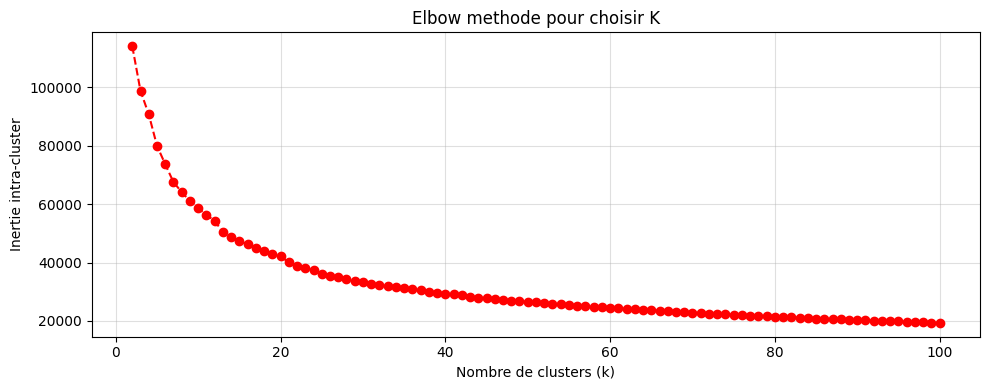

In [13]:
plot_elbow_method(X_test, k_max= 100, n_components= 10)

D'après la elbow method, le nombre de cluster semble être entre 7 et 10 clusters.
Asymptote au delà de 20.

### Silhouette score

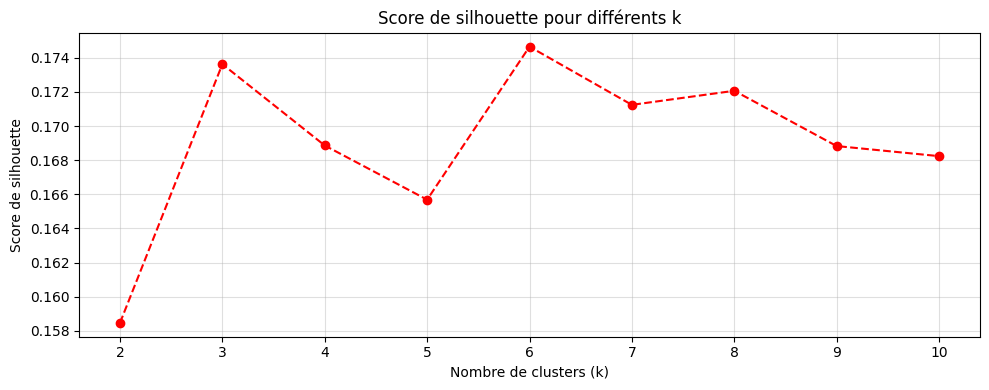

In [40]:
plot_silhouette_scores(X_test, k_max= 10, n_components= 10) #* faire avec k_max= 100 pour mieux visualiser

Sweet spot semble être à k=10 ou k=20 clusters. Plateau vers k=60.

# Regression linéaire et non linéaire

In [34]:
def evaluate_model(model, X_test, y_test):
    ''''''

    y_pred = model.predict(X_test)
    print(f"MAE : {mean_absolute_error(y_test, y_pred):,.0f} €")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):,.0f} €")
    print(f"R² : {r2_score(y_test, y_pred):.3f}")

    plt.figure()
    plt.scatter(y_test, y_pred, alpha= .2, color= "r")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel("Prix réel (€)")
    plt.ylabel("Prix prédit (€)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_trunc, test_size= .3, shuffle= True)

MAE : 307,106 €
RMSE : 802,604 €
R² : 0.134


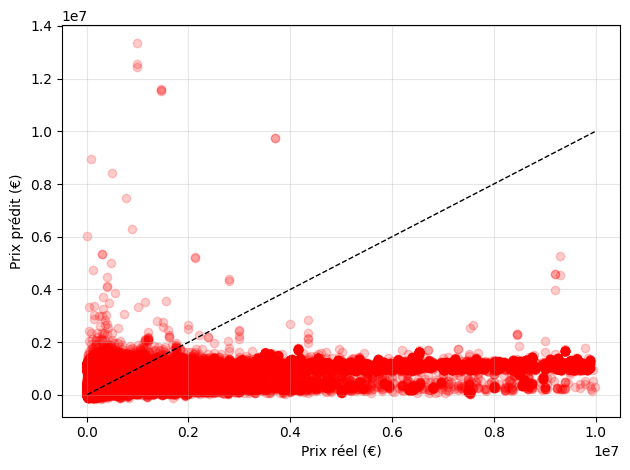

In [35]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
evaluate_model(model_lr, X_test, y_test)

MAE : 172,679 €
RMSE : 511,326 €
R² : 0.649


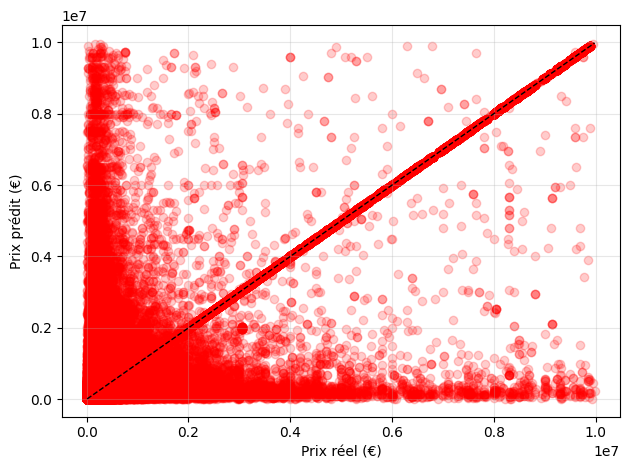

In [30]:
model_tree = DecisionTreeRegressor(max_depth= 100)
model_tree.fit(X_train, y_train)
evaluate_model(model_tree, X_test, y_test)

MAE : 195,957 €
RMSE : 495,394 €
R² : 0.670


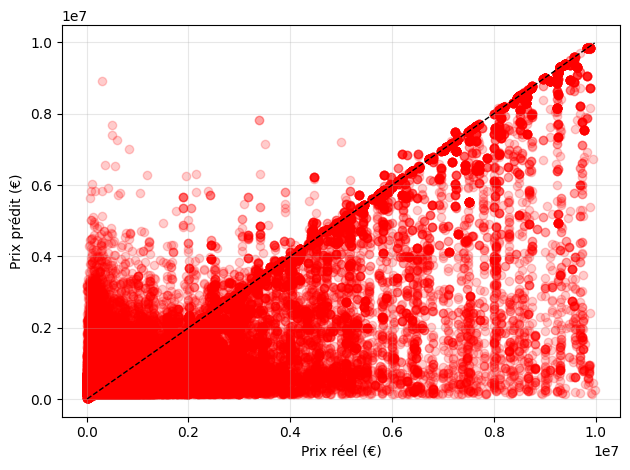

In [36]:
model_randomforest = RandomForestRegressor(n_estimators= 10, max_depth= 15)
model_randomforest.fit(X_train, y_train)
evaluate_model(model_randomforest, X_test, y_test)

# Neural Network & models

In [ ]:
#* Juste pour teste sur CG en local

# k = 16
# model = Sequential()
# model.add(Dense(128, activation= 'relu', input_dim= (X_train.shape[1])))
# model.add(Dense(64, activation= 'relu'))
# model.add(Dense(1))
# model.summary()

# model.compile(optimizer= Adam(learning_rate= 0.1 * k), loss= "mse", metrics=['acc'])

In [ ]:
# # batch_size = X_train.shape[0] * 8 #* Attention uniquement pour travailler sur la 3090 sinon
# batch_size = 256
# history = model.fit(X_train, y_train,
#     batch_size=         batch_size,
#     epochs=             100,
#     validation_split=   0.3,
#     verbose=            1)
# # ev = model.evaluate(X_test, y_test)
# # print(ev)

 